In [1]:
import gzip
import string
import math
import pandas as pd
import random
import numpy as np
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
def readGz(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

In [3]:
userItems = []

for d in readGz("australian_users_items.json.gz"):
    userItems.append(d)


In [4]:
features = []
for d in userItems:
    for i in d['items']:
        features.append((d['user_id'], i['item_name'], i['playtime_forever']))

In [5]:
len(features)

5153209

In [6]:
itemsPerUser = defaultdict(set)
usersPerItem = defaultdict(set)

for f in features:
    u = f[0]
    i = f[1]
    t = f[2]
    if t > 0:
        itemsPerUser[u].add(i)
        usersPerItem[i].add(u)

In [7]:
df = pd.DataFrame(features, columns = ['User', 'Game', 'Playtime(min)'])
df = df.reset_index(drop=True)
df['Played'] = df['Playtime(min)'] > 0
df = df.drop('Playtime(min)', axis=1)
df.head(10)

,User,Game,Played
0,76561197970982479,Counter-Strike,True
1,76561197970982479,Team Fortress Classic,False
2,76561197970982479,Day of Defeat,True
3,76561197970982479,Deathmatch Classic,False
4,76561197970982479,Half-Life: Opposing Force,False
5,76561197970982479,Ricochet,False
6,76561197970982479,Half-Life,False
7,76561197970982479,Half-Life: Blue Shift,False
8,76561197970982479,Day of Defeat: Source,True
9,76561197970982479,Counter-Strike: Source,True


In [8]:
len(df)

5153209

In [9]:
#Train-validation split
train = df.iloc[:200000]
validation = df.iloc[200000:300000]

In [10]:
gameCount = defaultdict(int)
totalPlayed = 0

for x in train.itertuples():
    gameCount[x.Game] += 1
    totalPlayed += 1

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

In [11]:
def baseline(train, valid, t=1.5):
    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalPlayed * t: break
        
    pred = []
    for x in valid.itertuples():
        if (x.Game in return1):
            pred.append(True)
        else:
            pred.append(False)
    valid['predB'] = pred
    accuracy = (valid.predB == valid['Played']).sum()/len(valid['Played'])
    return accuracy

In [12]:
baseline(train, validation, 0.6)

C:\Users\wanga\AppData\Local\Temp\ipykernel_13880\795721309.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predB'] = pred


0.62353

C:\Users\wanga\AppData\Local\Temp\ipykernel_13880\795721309.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predB'] = pred


Best Threshold: 0.85
Best Accuracy: 0.66342


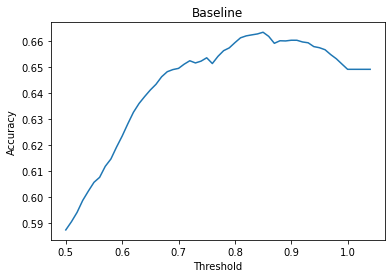

In [13]:
X = [i/100 for i in range(50,105) ]
y = []
best_acc = 0
for t in range(50,105):
    acc = baseline(train,validation, (t / 100))
    y.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_t = t

plt.plot(X,y)
print('Best Threshold:', best_t/100)
print('Best Accuracy:', best_acc)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Baseline')
plt.show()

In [14]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [15]:
itemsPerUserTrain = defaultdict(set)
usersPerItemTrain = defaultdict(set)

for x in train.itertuples():
    if x.Played:
        itemsPerUserTrain[x.User].add(x.Game)
        usersPerItemTrain[x.Game].add(x.User)

In [16]:
# Calculate similarities for everything so we don't have to calculate every time we run
sims = defaultdict(int)
for x in validation.itertuples():
    for game in itemsPerUser[x.User]:
        if x.Game == game:
            continue
        sim = Jaccard(usersPerItemTrain[x.Game], usersPerItemTrain[game])
        sims[(x.User, x.Game, game)] = sim

In [17]:
def jac_pred(train, valid, t=0.05):
    pred = []
    for x in valid.itertuples():
        maxSim = 0
        
        # finding max jacc sim based on users
        for game in itemsPerUser[x.User]:
            sim = sims[x.User, x.Game, game]
            if sim > maxSim:
                maxSim = sim
                if sim > t:
                    break
                    
        if ((maxSim > t)):
            pred.append(True)
        else:
            pred.append(False)
    valid['predJ'] = pred
    return (valid.predJ == valid.Played).sum()/len(valid.Played)

In [18]:
jac_pred(train,validation)

C:\Users\wanga\AppData\Local\Temp\ipykernel_13880\4282658129.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predJ'] = pred


0.67612

C:\Users\wanga\AppData\Local\Temp\ipykernel_13880\4282658129.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predJ'] = pred


Best Threshold: 0.09
Best Accuracy: 0.68227


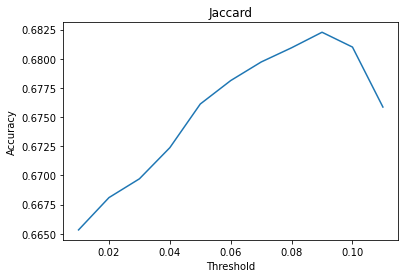

In [19]:
X = [i/100 for i in range(1,12) ]
y = []
best_acc = 0
for t in range(1,12):
    acc = jac_pred(train,validation, (t / 100))
    y.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_t = t

plt.plot(X,y)
print('Best Threshold:', best_t/100)
print('Best Accuracy:', best_acc)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Jaccard')
plt.show()

In [20]:
def Cosine(s1, s2):
    numer = len(s1.intersection(s2))
    denom = math.sqrt(len(s1)) * math.sqrt(len(s2))
    if denom == 0:
        return 0
    return numer / denom

In [21]:
# Calculate similarities for everything so we don't have to calculate every time we run
sims = defaultdict(int)
for x in validation.itertuples():
    for game in itemsPerUser[x.User]:
        if x.Game == game:
            continue
        sim = Cosine(usersPerItemTrain[x.Game], usersPerItemTrain[game])
        sims[(x.User, x.Game, game)] = sim

In [22]:
def cos_pred(train, valid, t=0.05):
    pred = []
    for x in valid.itertuples():
        maxSim = 0
        
        # finding max cos sim based on users
        for game in itemsPerUser[x.User]:
            sim = sims[x.User, x.Game, game]
            if sim > maxSim:
                maxSim = sim
                if sim > t:
                    break
                    
        if ((maxSim > t)):
            pred.append(True)
        else:
            pred.append(False)
    valid['predC'] = pred
    return (valid.predC == valid.Played).sum()/len(valid.Played)

In [23]:
cos_pred(train,validation)

C:\Users\wanga\AppData\Local\Temp\ipykernel_13880\2418308098.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predC'] = pred


0.66318

C:\Users\wanga\AppData\Local\Temp\ipykernel_13880\2418308098.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predC'] = pred


Best Threshold: 0.2
Best Accuracy: 0.6741


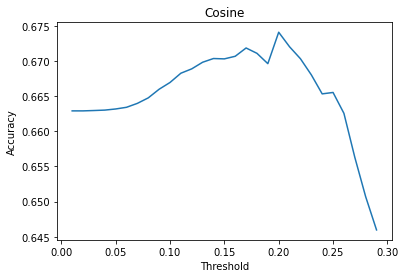

In [24]:
X = [i/100 for i in range(1,30) ]
y = []
best_acc = 0
for t in range(1,30):
    acc = cos_pred(train,validation, (t / 100))
    y.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_t = t

plt.plot(X,y)
print('Best Threshold:', best_t/100)
print('Best Accuracy:', best_acc)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Cosine')
plt.show()